In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saniyaa01","key":"136ae9f18d5db455a1b8c8033ec30b41"}'}

#access kaggle

In [ ]:
import os
import zipfile

# Step 1: Make a directory for the Kaggle token
os.makedirs("/root/.kaggle", exist_ok=True)

# Step 2: Move the uploaded kaggle.json to that directory
!mv kaggle.json /root/.kaggle/kaggle.json

# Step 3: Set proper permissions (important!)
!chmod 600 /root/.kaggle/kaggle.json

# Step 4: Now  download the dataset using Kaggle CLI
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

# Step 5: Unzip the downloaded file
with zipfile.ZipFile("covid19-radiography-database.zip", "r") as zip_ref:
    zip_ref.extractall("covid19-radiography-dataset")


Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 85% 662M/778M [00:00<00:00, 1.34GB/s]
100% 778M/778M [00:00<00:00, 1.28GB/s]


# train -test split

In [ ]:
import os
import shutil
from pathlib import Path
import random

random.seed(42)

# Set paths for source (downloaded data) and destination (processed train/test)
source_dir = Path("/content/covid19-radiography-dataset/COVID-19_Radiography_Dataset")
dest_dir = Path("/content/data/processed")  # You can change to anything you like

train_dir = dest_dir / "train_data_with_masks"
test_dir = dest_dir / "test_data_with_masks"

classes = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
split_ratio = 0.85

for cls in classes:
    print(f"Processing class: {cls}")

    # Paths to images and masks in raw data
    images_path = source_dir / cls / "images"
    masks_path = source_dir / cls / "masks"

    # List image files only
    all_images = [img for img in os.listdir(images_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(all_images)

    split_index = int(len(all_images) * split_ratio)
    train_imgs = all_images[:split_index]
    test_imgs = all_images[split_index:]

    # Create destination directories
    train_img_dir = train_dir / cls / "images"
    train_mask_dir = train_dir / cls / "masks"
    test_img_dir = test_dir / cls / "images"
    test_mask_dir = test_dir / cls / "masks"

    train_img_dir.mkdir(parents=True, exist_ok=True)
    train_mask_dir.mkdir(parents=True, exist_ok=True)
    test_img_dir.mkdir(parents=True, exist_ok=True)
    test_mask_dir.mkdir(parents=True, exist_ok=True)

    # Copy images and corresponding masks
    for img in train_imgs:
        shutil.copy(images_path / img, train_img_dir / img)
        mask_file = masks_path / img
        if mask_file.exists():
            shutil.copy(mask_file, train_mask_dir / img)

    for img in test_imgs:
        shutil.copy(images_path / img, test_img_dir / img)
        mask_file = masks_path / img
        if mask_file.exists():
            shutil.copy(mask_file, test_mask_dir / img)

    print(f"  Copied {len(train_imgs)} images (and masks if available) to {train_img_dir}")
    print(f"  Copied {len(test_imgs)} images (and masks if available) to {test_img_dir}")

Processing class: Normal
  Copied 8663 images (and masks if available) to /content/data/processed/train_data_with_masks/Normal/images
  Copied 1529 images (and masks if available) to /content/data/processed/test_data_with_masks/Normal/images
Processing class: COVID
  Copied 3073 images (and masks if available) to /content/data/processed/train_data_with_masks/COVID/images
  Copied 543 images (and masks if available) to /content/data/processed/test_data_with_masks/COVID/images
Processing class: Lung_Opacity
  Copied 5110 images (and masks if available) to /content/data/processed/train_data_with_masks/Lung_Opacity/images
  Copied 902 images (and masks if available) to /content/data/processed/test_data_with_masks/Lung_Opacity/images
Processing class: Viral Pneumonia
  Copied 1143 images (and masks if available) to /content/data/processed/train_data_with_masks/Viral Pneumonia/images
  Copied 202 images (and masks if available) to /content/data/processed/test_data_with_masks/Viral Pneumonia/

#train val split + Augment + normalize

In [ ]:
#-------train and validation set preparation.-----
#Load the image and mask together.
#Resize both to (224, 224).
#Normalize both.
#Stack the mask as a 4th channel.
#Apply augmentations jointly on image+mask so they stay aligned.
#Yield the combined 4-channel tensor along with the label.

!pip install albumentations

import tensorflow as tf
import albumentations as A
import cv2
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

IMG_HEIGHT, IMG_WIDTH = 224, 224
NUM_CLASSES = 4
BATCH_SIZE = 16

CLASSES = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
CLASS_TO_INDEX = {cls: idx for idx, cls in enumerate(CLASSES)}

DATA_DIR = Path("/content/data/processed/train_data_with_masks")

# Albumentations augmentation pipeline
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=0, p=0.5),
])

# ----------- Dataset Preparation -----------

all_img_paths = []
all_class_indices = []

for class_name in CLASSES:
    class_dir = DATA_DIR / class_name / "images"
    img_files = list(class_dir.glob("*"))
    for img_file in img_files:
        all_img_paths.append(str(img_file))
        all_class_indices.append(CLASS_TO_INDEX[class_name])

# Train/val split
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    all_img_paths, all_class_indices, test_size=0.2, stratify=all_class_indices, random_state=42
)

# ----------- Data Generator -----------
def load_image_and_mask(img_path, mask_path, augment_data=False):
    # Load grayscale image
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img.astype(np.float32) / 255.0

    # Load mask (grayscale)
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    mask = mask.astype(np.float32) / 255.0

    #  Apply the mask to the image before stacking
    img = img * mask  # Now the image has non-zero pixels only in lung area

    # Apply augmentation
    if augment_data:
        augmented = augment(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']

    # Re-stack image + mask
    img_3ch = np.stack([img]*3, axis=-1)
    mask_ch = np.expand_dims(mask, axis=-1)
    img_with_mask = np.concatenate([img_3ch, mask_ch], axis=-1)

    return img_with_mask


# Count how many images per class
from collections import Counter
class_counts = Counter(train_labels)
mean_count = np.mean(list(class_counts.values()))

# Define minority class indices (you can tweak this logic as needed)
minority_classes = [cls for cls, count in class_counts.items() if count < mean_count]

def classification_generator(img_paths, labels):
    for img_path, label in zip(img_paths, labels):
        img_path_obj = Path(img_path)
        mask_path = img_path_obj.parent.parent / "masks" / img_path_obj.name

        # Augment only if label is a minority class
        augment_data = label in minority_classes

        img_with_mask = load_image_and_mask(img_path, mask_path, augment_data=augment_data)
        yield img_with_mask, label


def create_classification_dataset(img_paths, labels, batch_size=16):
    dataset = tf.data.Dataset.from_generator(
        lambda: classification_generator(img_paths, labels),
        output_signature=(
            tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 4), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )
    dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_classification_dataset(train_imgs, train_labels, batch_size=BATCH_SIZE)
val_dataset = create_classification_dataset(val_imgs, val_labels, batch_size=BATCH_SIZE)

print(f"Train batches: {len(list(train_dataset))}")
print(f"Validation batches: {len(list(val_dataset))}")



/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Train batches: 900
Validation batches: 225


#visualise image with mask

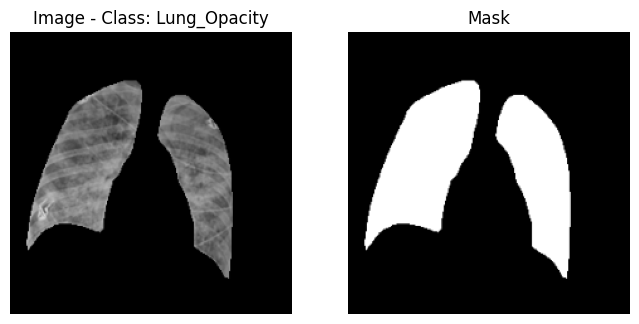

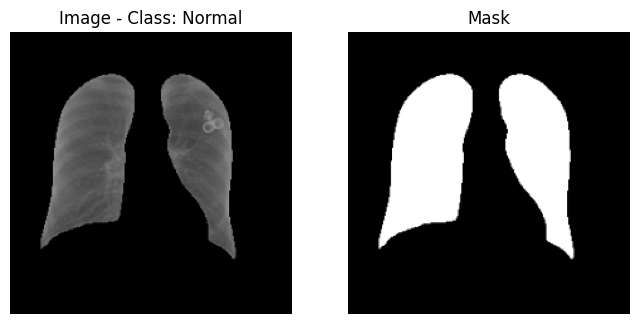

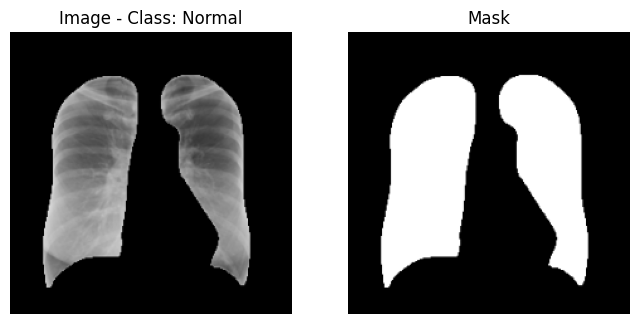

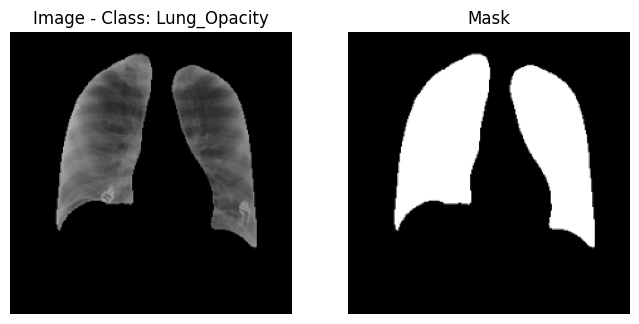

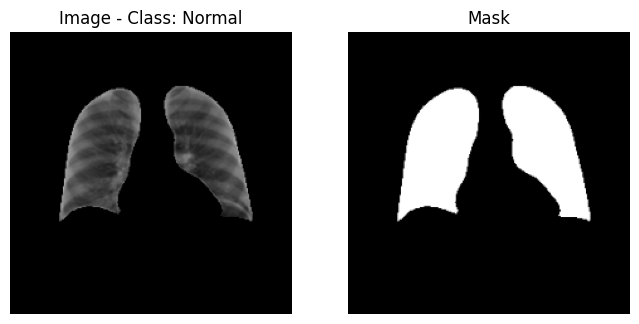

In [ ]:
import matplotlib.pyplot as plt

def show_image_with_mask(img_with_mask_tensor, label):
    img_with_mask = img_with_mask_tensor.numpy()
    img = img_with_mask[:, :, :3]
    mask = img_with_mask[:, :, 3]

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Image - Class: {CLASSES[label]}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    plt.show()

# Visualize a few training examples
for img_with_mask_tensor, label in train_dataset.take(1):
    for i in range(5):  # Show first 5 samples in the batch
        show_image_with_mask(img_with_mask_tensor[i], label[i].numpy())


# prepare test dataset

In [ ]:
# ----------- Test Dataset Preparation -----------

TEST_DATA_DIR = Path("/content/data/processed/test_data_with_masks")

test_img_paths = []
test_labels = []

for class_name in CLASSES:
    class_dir = TEST_DATA_DIR / class_name / "images"
    img_files = list(class_dir.glob("*"))
    for img_file in img_files:
        test_img_paths.append(str(img_file))
        test_labels.append(CLASS_TO_INDEX[class_name])

# Generator (no augmentation for test)
def classification_test_generator(img_paths, labels):
    for img_path, label in zip(img_paths, labels):
        img_path_obj = Path(img_path)
        mask_path = img_path_obj.parent.parent / "masks" / img_path_obj.name
        img_with_mask = load_image_and_mask(img_path, mask_path, augment_data=False)
        yield img_with_mask, label

# Create tf.data.Dataset
def create_test_dataset(img_paths, labels, batch_size=16):
    dataset = tf.data.Dataset.from_generator(
        lambda: classification_test_generator(img_paths, labels),
        output_signature=(
            tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 4), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Final test dataset
test_dataset = create_test_dataset(test_img_paths, test_labels, batch_size=BATCH_SIZE)

print(f"Test batches: {len(list(test_dataset))}")


Test batches: 199


# model preparation

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation

def build_4ch_cnn_model(input_shape=(224, 224, 4), num_classes=4):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3,3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(64, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(128, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = build_4ch_cnn_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,868 (628.39 KB)

 Trainable params: 160,420 (626.64 KB)

 Non-trainable params: 448 (1.75 KB)

# train

In [ ]:
EPOCHS = 20
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3)
    ]
)


Epoch 1/20
    900/Unknown 65s 63ms/step - accuracy: 0.6251 - loss: 0.9120

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


900/900 ━━━━━━━━━━━━━━━━━━━━ 79s 79ms/step - accuracy: 0.6252 - loss: 0.9118 - val_accuracy: 0.1709 - val_loss: 10.5543 - learning_rate: 0.0010
Epoch 2/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 67s 74ms/step - accuracy: 0.7882 - loss: 0.5704 - val_accuracy: 0.6504 - val_loss: 0.9434 - learning_rate: 0.0010
Epoch 3/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 67s 74ms/step - accuracy: 0.8175 - loss: 0.5066 - val_accuracy: 0.1729 - val_loss: 6.7855 - learning_rate: 0.0010
Epoch 4/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 68s 75ms/step - accuracy: 0.8346 - loss: 0.4626 - val_accuracy: 0.7532 - val_loss: 0.6456 - learning_rate: 0.0010
Epoch 5/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 67s 74ms/step - accuracy: 0.8436 - loss: 0.4458 - val_accuracy: 0.4875 - val_loss: 2.8972 - learning_rate: 0.0010
Epoch 6/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 67s 74ms/step - accuracy: 0.8532 - loss: 0.4331 - val_accuracy: 0.7629 - val_loss: 0.6710 - learning_rate: 0.0010
Epoch 7/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 66s 73ms/step - accuracy: 0.8534 - loss: 0.430

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


199/199 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.8520 - loss: 0.4608
Test Accuracy: 0.7399, Test Loss: 0.8071


#confusion matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Gather predictions
y_true = []
y_pred = []

for batch in val_dataset:
    imgs, labels = batch
    preds = model.predict(imgs)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

# plot epoch loss and accuracy

NameError: name 'history' is not defined

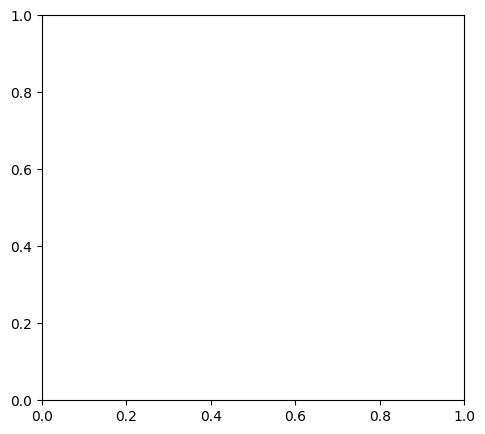

In [1]:
#plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# plot confusion matrix

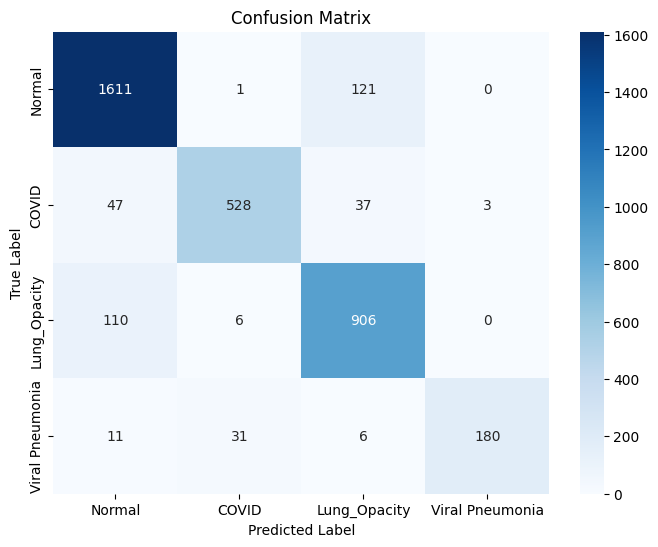

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# save model

In [ ]:


from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/model_cnnmask1.keras'
model.save(save_path)

Mounted at /content/drive
